## Project 5 Enron POI Identification
### By: Darren Liu

In [96]:
# initial setup
import warnings
warnings.filterwarnings("ignore")

import sys
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pprint import pprint

from sklearn.cross_validation import train_test_split
from sklearn.feature_selection import SelectPercentile, f_classif, SelectKBest
from sklearn.feature_extraction import DictVectorizer

from sklearn.decomposition import PCA
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.preprocessing import Imputer, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

%matplotlib inline

sys.path.append("../tools/")

# Udacity provided modules
from feature_format import featureFormat, targetFeatureSplit
from tester import test_classifier, dump_classifier_and_data


In [97]:
### Load the dictionary containing the dataset
with open("final_project_dataset.pkl", "r") as data_file:
    data_dict = pickle.load(data_file)

In [174]:
len([x for x in data_dict if data_dict[x]['poi']])

18

In [98]:
# remove total and email address
data_dict.pop('TOTAL', 0)
[data_dict[p].pop('email_address', 0) for p in data_dict.keys()]

['mark.metts@enron.com',
 'NaN',
 'steven.elliott@enron.com',
 'bill.cordes@enron.com',
 'kevin.hannon@enron.com',
 'kristina.mordaunt@enron.com',
 'rockford.meyer@enron.com',
 'jeffrey.mcmahon@enron.com',
 'stanley.horton@enron.com',
 'greg.piper@enron.com',
 'gene.humphrey@enron.com',
 'adam.umanoff@enron.com',
 'jeremy.blachman@enron.com',
 'marty.sunde@enron.com',
 'dana.gibbs@enron.com',
 'NaN',
 'wes.colwell@enron.com',
 's..muller@enron.com',
 'charlene.jackson@enron.com',
 'dick.westfahl@enron.com',
 'NaN',
 'rob.walls@enron.com',
 'louise.kitchen@enron.com',
 'NaN',
 'NaN',
 'jeffrey.shankman@enron.com',
 'john.wodraska@enron.com',
 'rick.bergsieker@enron.com',
 'NaN',
 'philippe.bibi@enron.com',
 'paula.rieker@enron.com',
 'NaN',
 'sally.beck@enron.com',
 'david.haug@enron.com',
 'john.echols@enron.com',
 'NaN',
 'gary.hickerson@enron.com',
 'NaN',
 'richard.lewis@enron.com',
 'robert.hayes@enron.com',
 'danny.mccarty@enron.com',
 'michael.kopper@enron.com',
 'dan.leff@enron.

### 1. Feature Selection
> The first step in making this decision is looking at data summary. The direction I want to take is using PCA transformation. Therefore, I plan to be lenient on feature selection at this step.

In [99]:
# quick transform of 'NaN' into None for Pandas summary description
dat_dict_pd = [{k: data_dict[p][k] if data_dict[p][k] != 'NaN' else None for k in data_dict[p].keys()} for p in data_dict.keys()]
dat_pd = pd.DataFrame(dat_dict_pd)

In [100]:
# overall summary
dat_pd.describe()

,bonus,deferral_payments,deferred_income,director_fees,exercised_stock_options,expenses,from_messages,from_poi_to_this_person,from_this_person_to_poi,loan_advances,long_term_incentive,other,poi,restricted_stock,restricted_stock_deferred,salary,shared_receipt_with_poi,to_messages,total_payments,total_stock_value
count,81.000000,38.000000,48.000000,16.000000,101.000000,94.000000,86.000000,86.000000,86.000000,3.000000,65.000000,92.000000,145,109.000000,17.000000,94.000000,86.000000,86.000000,1.240000e+02,125.000000
mean,1201773.074074,841602.526316,-581049.812500,89822.875000,2959559.257426,54192.010638,608.790698,64.895349,41.232558,27975000.000000,746491.200000,465276.663043,0.124138,1147424.091743,621892.823529,284087.542553,1176.465116,2073.860465,2.623421e+06,3352073.024000
std,1441679.438330,1289322.626180,942076.402972,41112.700735,5499449.598994,46108.377454,1841.033949,86.979244,100.073111,46382560.030684,862917.421568,1389719.064851,0.330882,2249770.356903,3845528.349509,177131.115377,1178.317641,2582.700981,9.488106e+06,6532883.097201
min,70000.000000,-102500.000000,-3504386.000000,3285.000000,3285.000000,148.000000,12.000000,0.000000,0.000000,400000.000000,69223.000000,2.000000,False,-2604490.000000,-1787380.000000,477.000000,2.000000,57.000000,1.480000e+02,-44093.000000
25%,425000.000000,79644.500000,-611209.250000,83674.500000,506765.000000,22479.000000,22.750000,10.000000,1.000000,1200000.000000,275000.000000,1209.000000,0,252055.000000,-329825.000000,211802.000000,249.750000,541.250000,3.863802e+05,494136.000000
50%,750000.000000,221063.500000,-151927.000000,106164.500000,1297049.000000,46547.500000,41.000000,35.000000,8.000000,2000000.000000,422158.000000,51984.500000,0,441096.000000,-140264.000000,258741.000000,740.500000,1211.000000,1.100246e+06,1095040.000000
75%,1200000.000000,867211.250000,-37926.000000,112815.000000,2542813.000000,78408.500000,145.500000,72.250000,24.750000,41762500.000000,831809.000000,357577.250000,0,985032.000000,-72419.000000,308606.500000,1888.250000,2634.750000,2.084663e+06,2606763.000000
max,8000000.000000,6426990.000000,-833.000000,137864.000000,34348384.000000,228763.000000,14368.000000,528.000000,609.000000,81525000.000000,5145434.000000,10359729.000000,True,14761694.000000,15456290.000000,1111258.000000,5521.000000,15149.000000,1.035598e+08,49110078.000000


In [101]:
# by POI summary
dat_pd.groupby('poi').describe()

bonus  deferral_payments  deferred_income  \
poi                                                               
False count       65.000000          33.000000        37.000000   
      mean    986824.923077      890346.212121   -445998.459459   
      std    1173879.759248     1341381.033477    762791.408207   
      min      70000.000000     -102500.000000  -3367011.000000   
      25%     400000.000000       85430.000000   -575000.000000   
      50%     700000.000000      260455.000000   -121284.000000   
      75%    1000000.000000      875307.000000    -36666.000000   
      max    8000000.000000     6426990.000000     -1042.000000   
True  count       16.000000           5.000000        11.000000   
      mean   2074999.937500      519894.200000  -1035313.454545   
      std    2047437.319350      912889.495638   1334971.876158   
      min     200000.000000       10259.000000  -3504386.000000   
      25%     775000.000000       27610.000000  -1860244.500000   
      50%    1275000.000000      202911.000000   -262500.000000   
      75%    2062500.000000      214678.000000   -122031.000000   
      max    7000000.000000     2144013.000000      -833.000000   

             director_fees  exercised_stock_options       expenses  \
poi                                                                  
False count      16.000000                89.000000      76.000000   
      mean    89822.875000           1947752.370787   52846.315789   
      std     41112.700735           2547067.767688   48036.089983   
      min      3285.000000              3285.000000     148.000000   
      25%     83674.500000            436515.000000   18254.000000   
      50%    106164.500000           1030329.000000   44601.000000   
      75%    112815.000000           2165172.000000   76764.750000   
      max    137864.000000          15364167.000000  228763.000000   
True  count       0.000000                12.000000      18.000000   
      mean             NaN          10463793.666667   59873.833333   
      std              NaN          12382588.130663   37524.658812   
      min              NaN            384728.000000   16514.000000   
      25%              NaN           1456581.000000   31323.250000   
      50%              NaN           3914557.000000   50448.500000   
      75%              NaN          19386043.750000   84125.000000   
      max              NaN          34348384.000000  127017.000000   

             from_messages  from_poi_to_this_person  from_this_person_to_poi  \
poi                                                                            
False count      72.000000                72.000000                72.000000   
      mean      668.763889                58.500000                36.277778   
      std      1978.997801                87.995198                85.139690   
      min        12.000000                 0.000000                 0.000000   
      25%        20.500000                10.000000                 0.000000   
      50%        41.000000                26.500000                 6.000000   
      75%       216.500000                61.750000                23.250000   
      max     14368.000000               528.000000               411.000000   
True  count      14.000000                14.000000                14.000000   
      mean      300.357143                97.785714                66.714286   
      std       805.844574                76.058862               158.289622   
      min        16.000000                13.000000                 4.000000   
      25%        33.000000                44.500000                12.500000   
      50%        44.500000                62.000000                15.500000   
      75%       101.500000               135.750000                28.750000   
      max      3069.000000               240.000000               609.000000   

               loan_advances  long_term_incentive            other  \
poi                                        

> I am going to keep all variables at this point. Although there are some questionable duds such as loan advances. We will remove variables at later steps as needed.

### 2. Outlier Removal - warning: LONG section
> It seems the prescribed training and remove 10% methodology from lecture does not translate well into this project. The first obvious difference is that residual error in regression does not exist in classification. Therefore, the methodology I am going to employ is comparing variable behavior between POI and non-POI by reviewing summaries and side-by-side boxplots.

In [102]:
vars_plt = dat_dict_pd[0].keys()
print len(vars_plt)

20


In [103]:
# normalize varibles for better view (brilliant solution from stackoverflow)
dat_plt = dat_pd
dat_plt -= dat_plt.min()
dat_plt /= dat_plt.max()
dat_plt.describe()

,bonus,deferral_payments,deferred_income,director_fees,exercised_stock_options,expenses,from_messages,from_poi_to_this_person,from_this_person_to_poi,loan_advances,long_term_incentive,other,poi,restricted_stock,restricted_stock_deferred,salary,shared_receipt_with_poi,to_messages,total_payments,total_stock_value
count,81.000000,38.000000,48.000000,16.000000,101.000000,94.000000,86.000000,86.000000,86.000000,3.000000,65.000000,92.000000,145.000000,109.000000,17.000000,94.000000,86.000000,86.000000,124.000000,125.000000
mean,0.142720,0.144591,0.834392,0.643027,0.086076,0.236397,0.041571,0.122908,0.067705,0.339908,0.133420,0.044912,0.124138,0.216047,0.139719,0.255325,0.212804,0.133638,0.025331,0.069092
std,0.181801,0.197461,0.268892,0.305491,0.160123,0.201686,0.128241,0.164733,0.164324,0.571742,0.169992,0.134146,0.330882,0.129549,0.223011,0.159465,0.213502,0.171130,0.091620,0.132906
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.044767,0.027896,0.825784,0.597341,0.014659,0.097680,0.000749,0.018939,0.001642,0.009861,0.040538,0.000117,0.000000,0.164489,0.084527,0.190249,0.044890,0.032087,0.003730,0.010950
50%,0.085750,0.049554,0.956874,0.764454,0.037670,0.202959,0.002020,0.066288,0.013136,0.019723,0.069527,0.005018,0.000000,0.175375,0.095520,0.232507,0.133810,0.076464,0.010623,0.023175
75%,0.142497,0.148513,0.989413,0.813871,0.073941,0.342324,0.009299,0.136837,0.040640,0.509861,0.150227,0.034516,0.000000,0.206696,0.099455,0.277399,0.341774,0.170802,0.020129,0.053929
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


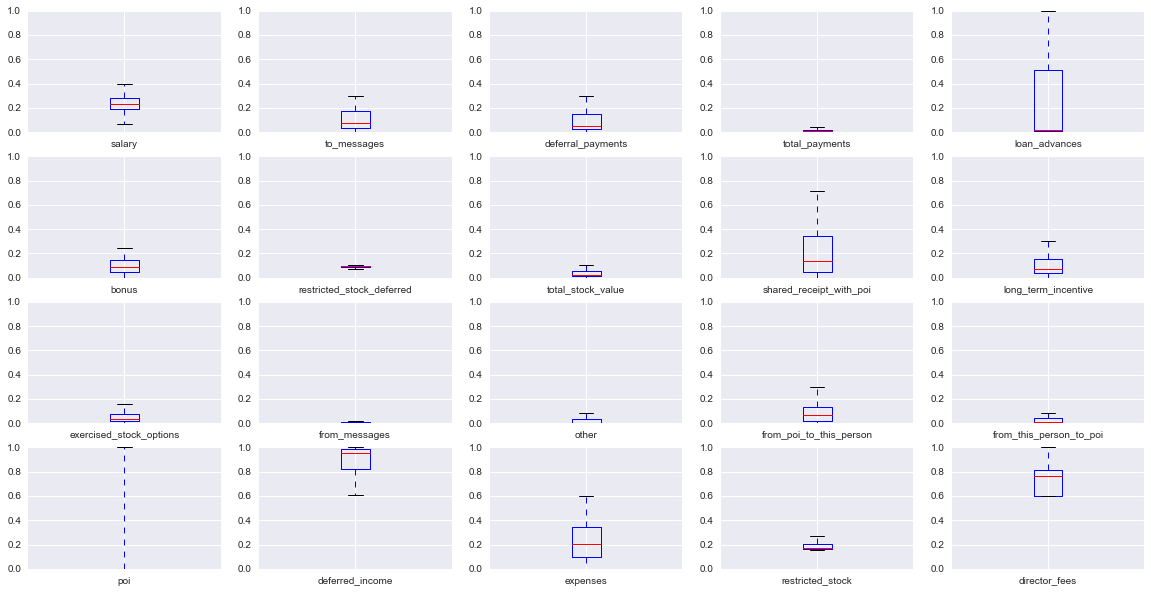

In [104]:
# boxplots
nrows = 4
ncols = 5

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 10))

for i in range(0, len(vars_plt)):
    nrow = int(i / ncols)
    ncol = i % ncols 
    dat_plt.boxplot(vars_plt[i], ax=axes[nrow,ncol])

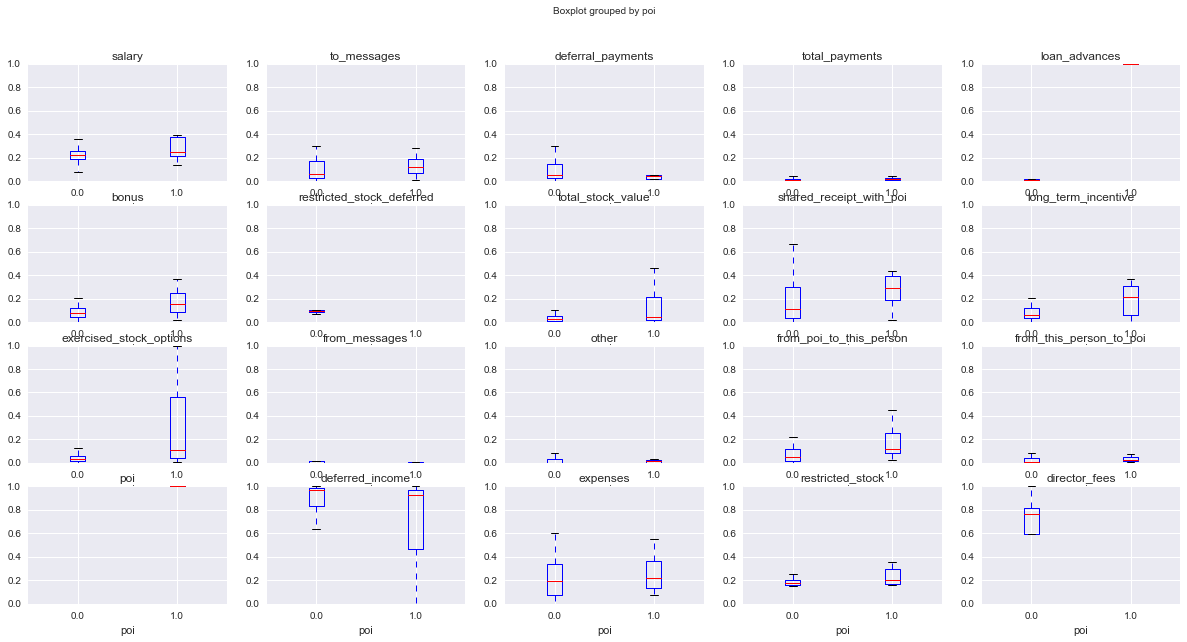

In [105]:
# boxplots by poi
nrows = 4
ncols = 5

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 10))

for i in range(0, len(vars_plt)):
    nrow = int(i / ncols)
    ncol = i % ncols 
    dat_plt.boxplot(vars_plt[i], by='poi', ax=axes[nrow,ncol])


> There are some oddballs, the dwarfed boxplots indicates the max is so much larger than the min that it squashes all the data points. We will investigate:
- total_payments
- loan_advances
- restricted_stock_deferred
- from_messages
- other
- from_this_person_to_poi

In [106]:
# Check out total_payments
dat_pd.total_payments.describe()

count    1.240000e+02
mean     2.623273e+06
std      9.488106e+06
min      0.000000e+00
25%      3.862322e+05
50%      1.100098e+06
75%      2.084515e+06
max      1.035596e+08
Name: total_payments, dtype: float64

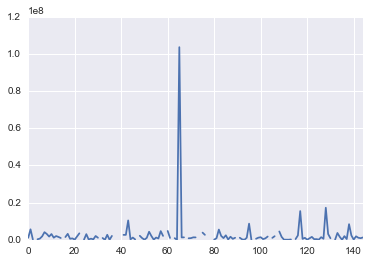

In [107]:
dat_pd.total_payments.plot() # appears to be only one

In [108]:
# oh of course, mr Lay
np.array(data_dict.keys())[np.array(dat_pd.total_payments == dat_pd.total_payments.max())]

array(['LAY KENNETH L'], 
      dtype='|S29')

In [109]:
# Check out loan_advances
dat_pd.loan_advances.describe() # Only 3, POI has by far bigger value

count           3.000000
mean     27575000.000000
std      46382560.030684
min             0.000000
25%        800000.000000
50%       1600000.000000
75%      41362500.000000
max      81125000.000000
Name: loan_advances, dtype: float64

In [110]:
np.array(data_dict.keys())[np.array(dat_pd.loan_advances >= 0)] # other than Lay, the others are innocent

array(['LAY KENNETH L', 'PICKERING MARK R', 'FREVERT MARK A'], 
      dtype='|S29')

In [111]:
# Check out restricted_stock_deferred
dat_pd.restricted_stock_deferred.describe()

count          17.000000
mean      2409272.823529
std       3845528.349509
min             0.000000
25%       1457555.000000
50%       1647116.000000
75%       1714961.000000
max      17243670.000000
Name: restricted_stock_deferred, dtype: float64

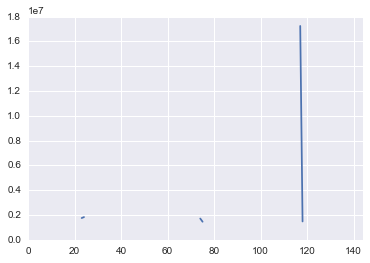

In [112]:
dat_pd.restricted_stock_deferred.plot() # appears to be one

In [113]:
np.array(data_dict.keys())[np.array(dat_pd.loan_advances == dat_pd.loan_advances.max())] # yes, of course

array(['LAY KENNETH L'], 
      dtype='|S29')

In [114]:
# Check out from_messages
dat_pd.from_messages.describe()

count       86.000000
mean       596.790698
std       1841.033949
min          0.000000
25%         10.750000
50%         29.000000
75%        133.500000
max      14356.000000
Name: from_messages, dtype: float64

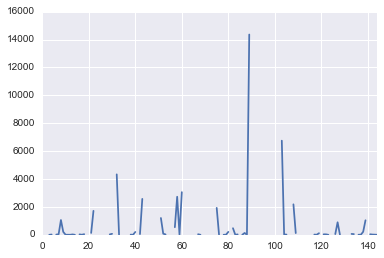

In [115]:
dat_pd.from_messages.plot() # review top 5%

In [116]:
# mostly non-POI
out = np.array(data_dict.keys())[np.array(dat_pd.from_messages > dat_pd.from_messages.quantile(.95))]
for o in out:
    pprint ({o: data_dict[o]})

{'BECK SALLY W': {'bonus': 700000,
                  'deferral_payments': 'NaN',
                  'deferred_income': 'NaN',
                  'director_fees': 'NaN',
                  'exercised_stock_options': 'NaN',
                  'expenses': 37172,
                  'from_messages': 4343,
                  'from_poi_to_this_person': 144,
                  'from_this_person_to_poi': 386,
                  'loan_advances': 'NaN',
                  'long_term_incentive': 'NaN',
                  'other': 566,
                  'poi': False,
                  'restricted_stock': 126027,
                  'restricted_stock_deferred': 'NaN',
                  'salary': 231330,
                  'shared_receipt_with_poi': 2639,
                  'to_messages': 7315,
                  'total_payments': 969068,
                  'total_stock_value': 126027}}
{'MCCONNELL MICHAEL S': {'bonus': 1100000,
                         'deferral_payments': 'NaN',
                         'deferred_

In [117]:
# Check out from_messages
dat_pd.other.describe()

count          92.000000
mean       465274.663043
std       1389719.064851
min             0.000000
25%          1207.000000
50%         51982.500000
75%        357575.250000
max      10359727.000000
Name: other, dtype: float64

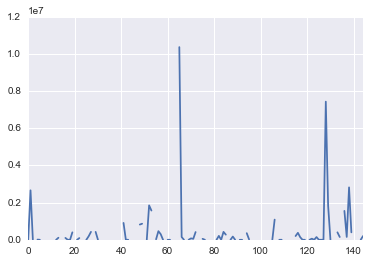

In [118]:
dat_pd.other.plot() # top 5%

In [119]:
# Lay has no bounds, the others non-POI
print np.array(data_dict.keys())[np.array(dat_pd.other == dat_pd.other.max())]
out = np.array(data_dict.keys())[np.array(dat_pd.other > dat_pd.other.quantile(.95))]
for o in out:
    pprint ({o: data_dict[o]})

['LAY KENNETH L']
{'BAXTER JOHN C': {'bonus': 1200000,
                   'deferral_payments': 1295738,
                   'deferred_income': -1386055,
                   'director_fees': 'NaN',
                   'exercised_stock_options': 6680544,
                   'expenses': 11200,
                   'from_messages': 'NaN',
                   'from_poi_to_this_person': 'NaN',
                   'from_this_person_to_poi': 'NaN',
                   'loan_advances': 'NaN',
                   'long_term_incentive': 1586055,
                   'other': 2660303,
                   'poi': False,
                   'restricted_stock': 3942714,
                   'restricted_stock_deferred': 'NaN',
                   'salary': 267102,
                   'shared_receipt_with_poi': 'NaN',
                   'to_messages': 'NaN',
                   'total_payments': 5634343,
                   'total_stock_value': 10623258}}
{'SHERRIFF JOHN R': {'bonus': 1500000,
                     'deferra

In [120]:
# Check out from_messages
dat_pd.from_this_person_to_poi.describe()

count     86.000000
mean      41.232558
std      100.073111
min        0.000000
25%        1.000000
50%        8.000000
75%       24.750000
max      609.000000
Name: from_this_person_to_poi, dtype: float64

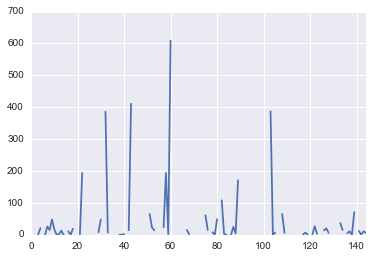

In [121]:
dat_pd.from_this_person_to_poi.plot() # check out 10%

In [122]:
print np.array(data_dict.keys())[np.array(dat_pd.from_this_person_to_poi == dat_pd.from_this_person_to_poi.max())]
out = np.array(data_dict.keys())[np.array(dat_pd.from_this_person_to_poi > dat_pd.from_this_person_to_poi.quantile(.95))]
for o in out:
    pprint ({o: data_dict[o]})

['DELAINEY DAVID W']
{'BECK SALLY W': {'bonus': 700000,
                  'deferral_payments': 'NaN',
                  'deferred_income': 'NaN',
                  'director_fees': 'NaN',
                  'exercised_stock_options': 'NaN',
                  'expenses': 37172,
                  'from_messages': 4343,
                  'from_poi_to_this_person': 144,
                  'from_this_person_to_poi': 386,
                  'loan_advances': 'NaN',
                  'long_term_incentive': 'NaN',
                  'other': 566,
                  'poi': False,
                  'restricted_stock': 126027,
                  'restricted_stock_deferred': 'NaN',
                  'salary': 231330,
                  'shared_receipt_with_poi': 2639,
                  'to_messages': 7315,
                  'total_payments': 969068,
                  'total_stock_value': 126027}}
{'LAVORATO JOHN J': {'bonus': 8000000,
                     'deferral_payments': 'NaN',
                     '

> After careful review, the decision is to drop Ken Lay. My argument is that his existence unnecessarily raises the bar for detection for other potential POI. On the by feature level, variables will be left alone for now. Total_payments, loan_advances, and restricted_stock_deferred were single handly Lay's doing, so they are fine. The email related variables will be transformed as they are poor standalone features. Other will be dropped, it is merely a retainer for other payments of non-importance.

> Other instances of extreme values from the mean are backed by similar stretch of the box. I interpret such behavior as meaningful variance as a result of skewed distributions. An interesting glaring variable is the exercised stock options. Although there are arguably outliers, it is easy to explain why the phenomenom exists (greedy people). Eliminating the so-called outliers here would be a mistake.

In [123]:
# data_dict.pop('LAY KENNETH L', 0)

### 3. Create new features
> Ratios will help stregthen this analysis. Some people just have a bigger pile to deal with, and could be falsely identified based on that fact alone. Emails is a strong example. One who sends a lot of emails may send often to both POI and non-POI, but one who sends many emails to POI only might raise suspicion.

In [124]:
# new variables
# deferred_income_ratio = deferred_income / total_payments
# exercised_stock_ratio = exercised_stock_options / total_stock_value
# to_poi_ratio = from_this_person_to_poi / from_messages
# from_poi_ratio = from_poi_to_this_person / to_messages
# 
for p in data_dict.keys():
    
    if data_dict[p]['deferred_income'] != 'NaN' and data_dict[p]['total_payments'] != 'NaN' and float(data_dict[p]['total_payments']) > 0:
        #data_dict[p].update({'deferred_income_ratio': 'NaN'})
        data_dict[p].update(
            {'deferred_income_ratio':
             - float(data_dict[p]['deferred_income']) / float(data_dict[p]['total_payments'])
            })
    else:
        data_dict[p].update({'deferred_income_ratio': 'NaN'})
        
    if data_dict[p]['exercised_stock_options'] != 'NaN' and data_dict[p]['restricted_stock'] != 'NaN' and float(data_dict[p]['restricted_stock']) > 0:
        #data_dict[p].update({'exercised_stock_ratio': 'NaN'})
        data_dict[p].update(
            {'exercised_stock_ratio':
             float(data_dict[p]['exercised_stock_options']) / float(data_dict[p]['restricted_stock'])
            })
    else:
        data_dict[p].update({'exercised_stock_ratio': 'NaN'})
    
    if data_dict[p]['from_this_person_to_poi'] != 'NaN' and data_dict[p]['from_messages'] != 'NaN' and float(data_dict[p]['from_messages']) > 0:
        #data_dict[p].update({'to_poi_ratio': 'NaN'})
        data_dict[p].update(
            {'to_poi_ratio':
             float(data_dict[p]['from_this_person_to_poi']) / float(data_dict[p]['from_messages'])
            })
    else:
        data_dict[p].update({'to_poi_ratio': 'NaN'})
        
    if data_dict[p]['from_poi_to_this_person'] != 'NaN' and data_dict[p]['to_messages'] != 'NaN' and float(data_dict[p]['to_messages']) > 0:
        #data_dict[p].update({'from_poi_ratio': 'NaN'})
        data_dict[p].update(
            {'from_poi_ratio':
             float(data_dict[p]['from_poi_to_this_person']) / float(data_dict[p]['to_messages'])
            })
    else:
        data_dict[p].update({'from_poi_ratio': 'NaN'})

In [125]:
dat_dict_pd = [{k: data_dict[p][k] if data_dict[p][k] != 'NaN' else None for k in data_dict[p].keys()} for p in data_dict.keys()]
dat_pd = pd.DataFrame(dat_dict_pd)
vars_plt = dat_dict_pd[0].keys()
print len(vars_plt)

24


In [126]:
# normalize varibles for better view (brilliant solution from stackoverflow)
dat_plt = dat_pd
dat_plt -= dat_plt.min()
dat_plt /= dat_plt.max()

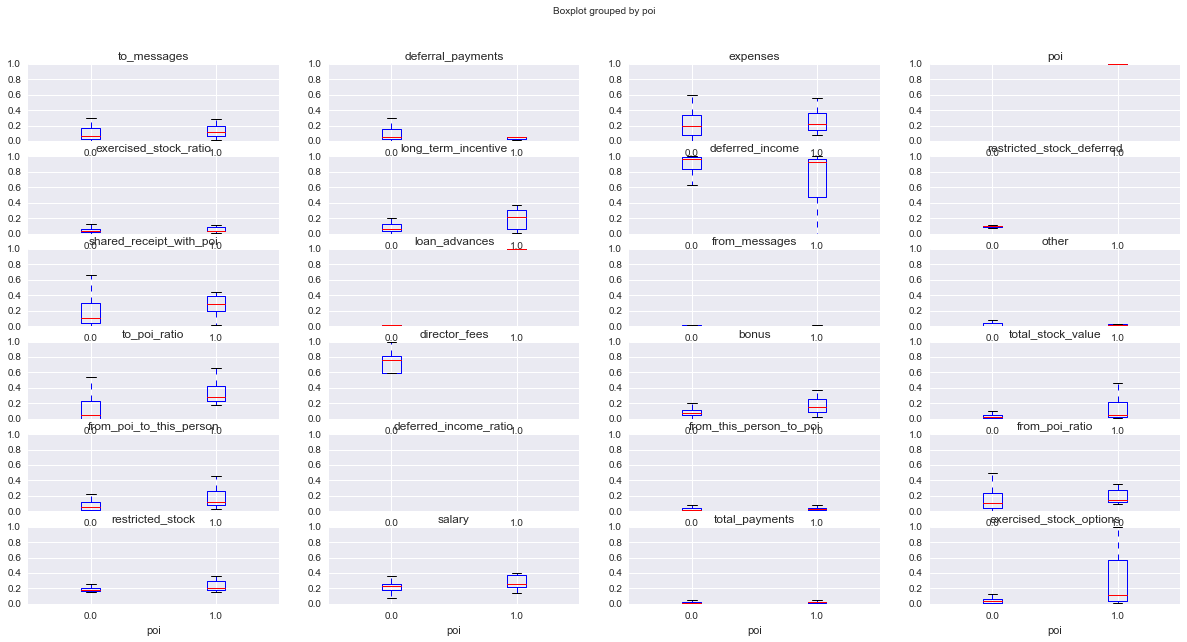

In [127]:
# boxplots
nrows = 6
ncols = 4

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 10))

for i in range(0, len(vars_plt)):
    nrow = int(i / ncols)
    ncol = i % ncols 
    dat_plt.boxplot(vars_plt[i], by='poi', ax=axes[nrow,ncol])

In [133]:
# handpicked variables



features_list = ['poi',
 'to_messages',
 #'deferral_payments',
 'bonus',
 'total_stock_value',
 'expenses',
 'from_poi_to_this_person',
 #'deferred_income_ratio',
 #'from_this_person_to_poi',
 #'exercised_stock_ratio',
 #'deferred_income',
 #'from_poi_ratio',
 'restricted_stock',
 'long_term_incentive',
 'salary',
 'total_payments',
 'loan_advances',
 #'restricted_stock_deferred',
 'shared_receipt_with_poi',
 'exercised_stock_options',
 #'from_messages',
 'other',
 'to_poi_ratio',
 #'director_fees'
]

features_list = ['poi',
 'to_messages',
 'deferral_payments',
 'bonus',
 'total_stock_value',
 'expenses',
 'from_poi_to_this_person',
 'deferred_income_ratio',
 'from_this_person_to_poi',
 'exercised_stock_ratio',
 'deferred_income',
 'from_poi_ratio',
 'restricted_stock',
 'long_term_incentive',
 'salary',
 'total_payments',
 'loan_advances',
 'restricted_stock_deferred',
 'shared_receipt_with_poi',
 'exercised_stock_options',
 'from_messages',
 'other',
 'to_poi_ratio',
 'director_fees'
]
my_dataset = {p: {k: data_dict[p][k] if data_dict[p][k] is not None else 'NaN' for k in data_dict[p] if k in features_list} for p in data_dict}

### 4. Classifiers
> I chose to do my own data formatting and transformation instead of the function provided by Udacity.

In [134]:
data = featureFormat(my_dataset, features_list, sort_keys = True)
labels, features = targetFeatureSplit(data)

In [135]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.3, random_state=42)

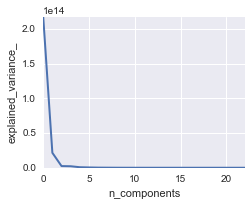

In [136]:
# Plot the PCA spectrum
pca = PCA()
pca.fit(X_train)
pca.explained_variance_

plt.figure(1, figsize=(4, 3))
plt.clf()
plt.axes([.2, .2, .7, .7])
plt.plot(pca.explained_variance_, linewidth=2)
plt.axis('tight')
plt.xlabel('n_components')
plt.ylabel('explained_variance_')

In [143]:
best = SelectKBest()
best.fit(X_train, y_train)
pprint (zip(features_list[1:], np.round(best.scores_, 0)))

[('to_messages', 3.0),
 ('deferral_payments', 0.0),
 ('bonus', 31.0),
 ('total_stock_value', 11.0),
 ('expenses', 4.0),
 ('from_poi_to_this_person', 5.0),
 ('deferred_income_ratio', 0.0),
 ('from_this_person_to_poi', 0.0),
 ('exercised_stock_ratio', 0.0),
 ('deferred_income', 8.0),
 ('from_poi_ratio', 0.0),
 ('restricted_stock', 8.0),
 ('long_term_incentive', 8.0),
 ('salary', 16.0),
 ('total_payments', 9.0),
 ('loan_advances', 7.0),
 ('restricted_stock_deferred', 1.0),
 ('shared_receipt_with_poi', 11.0),
 ('exercised_stock_options', 10.0),
 ('from_messages', 0.0),
 ('other', 3.0),
 ('to_poi_ratio', 14.0),
 ('director_fees', 2.0)]


In [91]:
# Chain PCA and Naive Bayes
estimators = [('best', SelectKBest(k=6)),
              #('pca', PCA()),
              ('NB', GaussianNB())]
clf_pca_nb = Pipeline(estimators)
params = dict(best__k=[5,6,7])
clf_pca_nb = GridSearchCV(clf_pca_nb, param_grid=params)
clf_pca_nb.fit(X_train, y_train)
print clf_pca_nb.best_estimator_

Pipeline(steps=[('best', SelectKBest(k=7, score_func=<function f_classif at 0x1151802a8>)), ('NB', GaussianNB())])


In [92]:
# results
#confusion_matrix(clf_pca_nb.predict(X_test), y_test)
test_classifier(clf_pca_nb, my_dataset, features_list)

GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(steps=[('best', SelectKBest(k=6, score_func=<function f_classif at 0x1151802a8>)), ('NB', GaussianNB())]),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'best__k': [5, 6, 7]}, pre_dispatch='2*n_jobs',
       refit=True, scoring=None, verbose=0)
	Accuracy: 0.84887	Precision: 0.41598	Recall: 0.33050	F1: 0.36835	F2: 0.34467
	Total predictions: 15000	True positives:  661	False positives:  928	False negatives: 1339	True negatives: 12072



In [176]:
# Chain PCA and SVM
estimators = [('norm', MinMaxScaler()),
              ('best', SelectKBest(k=14)),
              #('pca', PCA(n_components=3)),
              ('svm', SVC(gamma='auto', class_weight='balanced'))]
clf_pca_svm = Pipeline(estimators)
params = dict(svm__C=[.001, .1, 1, 10, 100])
clf_pca_svm = GridSearchCV(clf_pca_svm, param_grid=params)
clf_pca_svm.fit(X_train, y_train)
print clf_pca_svm.best_estimator_

Pipeline(steps=[('norm', MinMaxScaler(copy=True, feature_range=(0, 1))), ('best', SelectKBest(k=14, score_func=<function f_classif at 0x1151802a8>)), ('svm', SVC(C=1, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))])


In [94]:
# results
#confusion_matrix(clf_pca_svm.predict(X_test), y_test)
test_classifier(clf_pca_svm, my_dataset, features_list)

Pipeline(steps=[('norm', MinMaxScaler(copy=True, feature_range=(0, 1))), ('best', SelectKBest(k=14, score_func=<function f_classif at 0x1151802a8>)), ('svm', SVC(C=1, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))])
	Accuracy: 0.75993	Precision: 0.31508	Recall: 0.68200	F1: 0.43103	F2: 0.55317
	Total predictions: 15000	True positives: 1364	False positives: 2965	False negatives:  636	True negatives: 10035



In [166]:
# Chain PCA and ada
estimators = [#('norm', MinMaxScaler()),
              ('best', SelectKBest(k=14)),
              ('pca', PCA(n_components=2)),
              ('ada', AdaBoostClassifier(n_estimators=30))]
clf_pca_ada = Pipeline(estimators)
#params = dict(best__k=[8])
#clf_pca_ada = GridSearchCV(clf_pca_ada, param_grid=params)
clf_pca_ada.fit(X_train, y_train)
#print clf_pca_ada.best_estimator_

Pipeline(steps=[('best', SelectKBest(k=14, score_func=<function f_classif at 0x1151802a8>)), ('pca', PCA(copy=True, n_components=2, whiten=False)), ('ada', AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=30, random_state=None))])

In [167]:
# results
#confusion_matrix(clf_pca_svm.predict(X_test), y_test)
test_classifier(clf_pca_ada, my_dataset, features_list)

Pipeline(steps=[('best', SelectKBest(k=14, score_func=<function f_classif at 0x1151802a8>)), ('pca', PCA(copy=True, n_components=2, whiten=False)), ('ada', AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=30, random_state=None))])
	Accuracy: 0.83127	Precision: 0.29992	Recall: 0.19900	F1: 0.23925	F2: 0.21336
	Total predictions: 15000	True positives:  398	False positives:  929	False negatives: 1602	True negatives: 12071



In [161]:
# Chain PCA and LogisticRegression
estimators = [#('norm', MinMaxScaler()),
              ('best', SelectKBest(k=17)),
              ('pca', PCA(n_components=3)),
              ('log', LogisticRegression(tol=1e-64, C=1e-3, class_weight='balanced'))]
clf_pca_log = Pipeline(estimators)
#params = dict(log__C=[.001, .01, .1])
#clf_pca_log = GridSearchCV(clf_pca_log, param_grid=params)
clf_pca_log.fit(X_train, y_train)
#print clf_pca_log.best_estimator_

Pipeline(steps=[('best', SelectKBest(k=17, score_func=<function f_classif at 0x1151802a8>)), ('pca', PCA(copy=True, n_components=3, whiten=False)), ('log', LogisticRegression(C=0.001, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=1e-64, verbose=0, warm_start=False))])

In [162]:
# results
test_classifier(clf_pca_log, my_dataset, features_list)

Pipeline(steps=[('best', SelectKBest(k=17, score_func=<function f_classif at 0x1151802a8>)), ('pca', PCA(copy=True, n_components=3, whiten=False)), ('log', LogisticRegression(C=0.001, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=1e-64, verbose=0, warm_start=False))])
	Accuracy: 0.74893	Precision: 0.26263	Recall: 0.48850	F1: 0.34161	F2: 0.41681
	Total predictions: 15000	True positives:  977	False positives: 2743	False negatives: 1023	True negatives: 10257



In [45]:
# k neighbors
clf_knc = KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='manhattan',
                               metric_params=None, n_neighbors=4, p=2, weights='distance')
clf_knc.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='manhattan',
           metric_params=None, n_jobs=1, n_neighbors=4, p=2,
           weights='distance')

In [46]:
confusion_matrix(clf_knc.predict(X_test), y_test)

array([[37,  5],
       [ 2,  0]])

In [47]:
dump_classifier_and_data(clf_pca_svm, my_dataset, features_list)

### Sources
- http://stackoverflow.com/questions/21764475/scaling-numbers-column-by-column-with-pandas-python

In [48]:
my_dataset

{'ALLEN PHILLIP K': {'bonus': 4175000,
  'deferral_payments': 2869717,
  'deferred_income': -3081055,
  'deferred_income_ratio': 0.6870542644993514,
  'director_fees': 'NaN',
  'exercised_stock_options': 1729541,
  'exercised_stock_ratio': 13.723575106921533,
  'expenses': 13868,
  'from_messages': 2195,
  'from_poi_ratio': 0.016195727084769126,
  'from_poi_to_this_person': 47,
  'from_this_person_to_poi': 65,
  'loan_advances': 'NaN',
  'long_term_incentive': 304805,
  'other': 152,
  'poi': False,
  'restricted_stock': 126027,
  'restricted_stock_deferred': -126027,
  'salary': 201955,
  'shared_receipt_with_poi': 1407,
  'to_messages': 2902,
  'to_poi_ratio': 0.029612756264236904,
  'total_payments': 4484442,
  'total_stock_value': 1729541},
 'BADUM JAMES P': {'bonus': 'NaN',
  'deferral_payments': 178980,
  'deferred_income': 'NaN',
  'deferred_income_ratio': 'NaN',
  'director_fees': 'NaN',
  'exercised_stock_options': 257817,
  'exercised_stock_ratio': 'NaN',
  'expenses': 3486,


In [49]:
### Extract features and labels from dataset for local testing
data = featureFormat(my_dataset, features_list, sort_keys = True)
labels, features = targetFeatureSplit(data)

# Scale data - only relevant for some classifiers, neutral for others
scaler = MinMaxScaler()
features1 = scaler.fit_transform(features)

# Test/Train data split
# 1. Using Unscaled Features
features_train, features_test, labels_train, labels_test = train_test_split(features, labels, test_size=0.3, random_state=42)

# 2. Using Scaled Features
features_train1, features_test1, labels_train1, labels_test1 = train_test_split(features1, labels, test_size=0.3, random_state=42)

# Classifier
clf_knc = KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='manhattan',
                               metric_params=None, n_neighbors=4, p=2, weights='distance')

# Apply the classifier to Scaled Data
clf_knc.fit(features_train1, labels_train1)
y_pred = clf_knc.predict(features_test1)

print "Classification report: Scaled Features" 
print classification_report(labels_test1, y_pred)
print ' '     

## Pipeline
pipeline = Pipeline([#('normalization', scaler),
                     ('pca', PCA()),
                     ('classifier', clf_knc)
])
clf = pipeline

# Apply the pipeline to Unscaled Data
clf.fit(features_train, labels_train)
y_pred1 = clf.predict(features_test)

print "Classification report: Pipeline" 
print classification_report(labels_test, y_pred1)
print ' '

dump_classifier_and_data(clf, my_dataset, features_list)

Classification report: Scaled Features
             precision    recall  f1-score   support

        0.0       0.90      0.97      0.94        39
        1.0       0.50      0.20      0.29         5

avg / total       0.86      0.89      0.86        44

 
Classification report: Pipeline
             precision    recall  f1-score   support

        0.0       0.88      0.95      0.91        39
        1.0       0.00      0.00      0.00         5

avg / total       0.78      0.84      0.81        44

 
